In [17]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Annotated, List, Dict
import random

from pydantic import BaseModel
from openai import OpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults

In [18]:
load_dotenv()

True

In [19]:
client = OpenAI()
web_search = TavilySearchResults(max_results=3)

model_name = 'gpt-4o-2024-11-20'
max_talk_length = 8

In [44]:
class GraphState(TypedDict):
    project_name: Annotated[str, "전문가 인터뷰 생성 프로젝트의 이름입니다."]
    service_description: Annotated[str, "서비스가 수행하는 기능과 목적에 대한 요약입니다."]
    target_users: Annotated[str, "이 서비스를 주로 사용할 사용자층을 설명하세요."]
    core_features: Annotated[str, "서비스가 제공하는 주요 기능 리스트입니다."]

    experts: Annotated[str, "해당 질문에 답변할 전문가의 페르소나를 설명하세요. 예: '30대 UX 디자이너', 'AI 윤리 연구자' 등."]
    interview_questions: Annotated[str, "전문가에게 던질 인터뷰 질문입니다. 구체적이고 현실적인 질문이어야 합니다."]
    problem_to_verify: Annotated[str, "이번 인터뷰를 통해 검토하거나 확인하고 싶은 주요 문제점을 작성하세요."]

    final_conversation: Annotated[str, "블로그 글 내용"]
    image_url: Annotated[str, "생성 이미지 url"]

    # domain: Annotated[str, "토론 분야"] 
    # topic: Annotated[str, "토론 주제"]
    # experts: Annotated[List[str], "도메인 전문가 리스트"]
    next_speaker: Annotated[str, "현재 발언자"]
    
    messages: Annotated[list, "대화 내역"]

In [45]:
class DomainExpert(BaseModel):
    domain: str
    topic: str
    domain_experts: List[str]

In [46]:
def expert_generator(state: GraphState) -> GraphState:
    expert_generation_system_prompt = f"""
    당신은 사용자가 입력한 문장에서 핵심 주제(도메인)를 파악하고, 해당 분야에서 활동하는 전문가 또는 직군 리스트를 생성하는 전문가 분류 도우미입니다.  
    사용자는 다양한 전문 분야에 대해 묻거나, 특정 분야의 전문가 예시를 알고 싶어할 수 있습니다.  
    당신은 다음과 같은 기준을 따릅니다:
    
    1. 문장에서 핵심 도메인(예: 의료, 정보기술, 건축, 식품과학, 에너지 등)을 파악합니다.  
    2. 핵심 도메인을 파악해서 흥미로운 토론 주제를 한가지 생성한다.
    3. 해당 도메인에서 실제로 활동하는 전문가 직군을 깊이 있고 다양하게 3가지 나열합니다.  
    4. 반드시 아래 형식의 JSON으로 응답합니다:

    # 출력 형식
      "domain": "핵심 도메인"
      "topic": "토론 주제",
      "experts": [
        "<전문가 예시1>",
        "<전문가 예시2>",
        "<전문가 예시3>"
      ]
    
    아래는 예시입니다 (단순 참고용이며, 그대로 복사하거나 반복하지 마세요):
    
    예시 1:  
    문장: 의료 분야에 어떤 전문가가 있을까?  
    응답:
      "domain: "의료"
      "topic": "환자 중심 치료를 위한 의료 데이터 통합의 필요성과 과제",
      "experts": [
        "임상시험 코디네이터",
        "의사",
        "생명과학자"
      ]
    
    
    예시 2:  
    문장: IT 업계에서 일하는 전문가들은 어떤 직무가 있을까?  
    응답:
      "domain": "정보 보안"
      "topic": "AI 기술의 발전이 IT 직무에 미치는 영향과 미래 전망",
      "experts": [
        "정보 보안 엔지니어",
        "머신러닝 엔지니어",
        "클라우드 인프라 엔지니어"
      ]
    
    
    주의: 위 예시는 단지 참고용이며, 그대로 복사하거나 반복하지 말고 입력된 문맥에 맞춰 적절히 응용하세요.
    """
    
    response = client.responses.parse(
        model=model_name,
        input=[
            {"role": "system", "content": expert_generation_system_prompt},
            {"role": "user", "content": state['prompt']}
        ],
        text_format=DomainExpert
    )

    experts_list = response.output_parsed.domain_experts
    topic = response.output_parsed.topic
    domain = response.output_parsed.domain

    # return GraphState(experts=experts_list)
    return {"experts": experts_list, "topic": topic, "messages": [topic], "domain": domain}

In [47]:
def supervisor_node(state: GraphState) -> GraphState:
    experts = state["experts"]
    current = state.get("next_speaker", None)

    if current is None:
        next_speaker = random.choice(experts)
    else:
        remaining = [e for e in experts if e != current]
        next_speaker = random.choice(remaining) if remaining else current  # 예외 방지용

    return {"next_speaker": next_speaker}

In [48]:
def expert_answer_generator(state: GraphState) -> GraphState:
    messages_str = "\n".join(state['messages'])

    system_prompt = f"""  
    ---
    🟦 서비스 정보
    - 프로젝트명: {state['project_name']}
    - 서비스 설명: {state['service_description']}
    - 핵심 기능: {state['core_features']}
    
    🟨 사용자 정보
    - 타깃 사용자: {state['target_users']}
    - 전문가 페르소나: {state['experts']}
    
    🟧 인터뷰 질문
    {state['interview_questions']}
    
    🟥 검토할 문제
    {state['problem_to_verify']}

    현재 당신은 "{state['next_speaker']}" 역할을 맡고 있으며, 오직 이 역할의 입장에서만 의견을 제시해야 합니다. 다른 전문가의 이름이나 발언을 포함해서는 안 됩니다.
    ---
    
    지침:
    - 지금까지의 대화 내용을 신중히 읽고 흐름과 주제를 파악하세요.
    - 오직 "{state['next_speaker']}"로서 한 번의 발언만 작성하세요.
    - 다른 전문가의 이름이나 발언을 포함하지 마세요.
    - 사용자 질문과 앞선 전문가들의 발언을 참고해 논리적이고 깊이 있는 의견을 제시하세요.
    - 필요 시 본인의 전문 지식을 보완하거나 관점을 명확히 표현하세요.
    - 반드시 전문가로서의 어휘와 태도를 유지하세요.
    - 응답은 간결하고 핵심적인 내용으로 구성하세요. 
    - 발언은 **최대 3문장** 이내로 작성하며, 가능하다면 최신 연구·가이드라인을 **1건 이상 간단히 언급**하세요
       (예: “2024년 NIPS 논문에 따르면 …”).
    - 이전 대화 내용이 없다면, 토론의 첫 발화자로서 주제를 소개하고 입장을 제시하세요.
    
    ## 이전 대화 내용
    {messages_str}
    """
    
    if len(state['messages']) == max_talk_length-1:
        system_prompt += "\n ## - 이번 발언은 토론의 **마무리 발언**입니다. 내용을 간결하게 정리하고 자신의 입장을 명확하게 요약해 주세요."
    
    user_prompt = "위 지침을 따라 현재 화자의 한 차례 발언만 작성해 주세요."

    response = client.responses.create(
        model=model_name,
        input=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
    )

    return {"messages": state["messages"] + [response.output_text]}

In [49]:
def conversation_to_blog(state: GraphState) -> GraphState:
    total_users = "\t".join(state['experts'])
    expert_conversation = "\n".join(state['messages'])
    
    system_prompt = """
    당신은 UX/UI 전문가이자 블로그 콘텐츠 마케터입니다.
    사용자가 제공한 전문가 대화 내용을 바탕으로,
    - 흥미로운 블로그 글을 작성해주세요.
    - 글은 쉽고 명확하며, 실제 사례와 통계를 적절히 포함하고,
    - 마지막에 CTA(Call to Action)를 포함하세요.
    
    글의 톤은 친근하지만 전문성을 유지해야 하며,
    구조는 [제목 - 도입 - 본문 - 실천 인사이트 - CTA] 순서로 작성합니다.
    """
    
    # 유저 프롬프트 (템플릿)
    user_prompt = f"""
    아래의 전문가 대화 내용을 바탕으로 블로그 글을 작성해주세요.
    
    전문가 대화:
    {expert_conversation}
    """
    
    response = client.responses.create(
        model=model_name,
        input=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
    )

    return {"final_conversation": response.output_text}

In [50]:
def blog_to_imageurl(state: GraphState) -> GraphState:
    system_prompt_for_image = """
    당신은 블로그 콘텐츠에 적합한 이미지를 기획하는 이미지 크리에이터 전문가입니다.
    
    아래에 블로그 글의 전문이 제공됩니다. 이 글의 주요 내용, 키워드, 감정, 전달하려는 메시지를 종합 분석하여 **DALL·E 3로 이미지를 생성하기 위한 영어 프롬프트**를 작성해주세요.
    
    🎯 **프롬프트 작성 조건:**
    - 프롬프트는 **영어**로 작성합니다.
    - **구체적이고 세부 묘사(detailed, cinematic, highly detailed, professional illustration, realistic 등)를 포함**하여 이미지 품질을 극대화합니다.
    - 이미지에 등장할 **배경, 주요 사물, 등장인물, 분위기, 색감, 카메라 앵글** 등을 구체적으로 적어주세요.
    - 블로그 주제와 일치하는 핵심 메시지를 시각적으로 가장 잘 전달할 수 있는 방향으로 작성합니다.
    - 만약 인물이 필요하지 않다면, 사람 없이 상징적 요소만 포함하도록 명시합니다.
    - 문장 끝에 **" --v 6 --ar 16:9"** 를 추가해 가로형 블로그 대표 이미지 비율을 지정합니다. (Midjourney 스타일을 참고했으나, DALL·E prompt의 경우 비율 명시는 제외 가능하니 툴에 맞게 수정)
    
    📝 **출력 형식:**
    """
    
    # 유저 프롬프트
    user_prompt_for_image = f"""
    블로그 글
    {state['final_conversation']}
    
    위 내용을 바탕으로 DALL-E에 입력할 이미지 프롬프트를 작성해주세요.
    """

    # 이미지 프롬프트 생성
    image_prompt_response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": system_prompt_for_image},
            {"role": "user", "content": user_prompt_for_image},
        ],
    )
    
    image_prompt = image_prompt_response.choices[0].message.content

    # DALL-E 이미지 생성
    image_response = client.images.generate(
        model="dall-e-3",
        prompt=image_prompt,
        size="1024x1024"
    )

    return {"image_url": image_response.data[0].url}

In [51]:
def check_discussion_length(state: GraphState) -> str:
    if len(state['messages']) < max_talk_length:
        return "more_discussion"
    else:
        return "FINISH"

In [52]:
workflow = StateGraph(GraphState)

# Node Define
# workflow.add_node("expert_generator", expert_generator)
workflow.add_node("supervisor_node", supervisor_node)
workflow.add_node("expert_answer_generator", expert_answer_generator)
workflow.add_node("conversation_to_blog", conversation_to_blog)
workflow.add_node("blog_to_imageurl", blog_to_imageurl)

# Edge Define 
# workflow.add_edge(START, "expert_generator")
# workflow.add_edge("expert_generator", "supervisor_node")
workflow.add_edge(START, "supervisor_node")
workflow.add_conditional_edges(
    "supervisor_node",
    check_discussion_length,
    {
        "more_discussion": "expert_answer_generator",
        "FINISH": "conversation_to_blog"
    }
)
workflow.add_edge("expert_answer_generator", "supervisor_node")
workflow.add_edge("conversation_to_blog", "blog_to_imageurl")
workflow.add_edge("blog_to_imageurl", END)
# workflow.add_edge("expert_generator", END)

# Memory 
# memory = MemorySaver()
graph = workflow.compile()

In [56]:
code = graph.get_graph(xray=True).draw_mermaid()
print(code)



---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	supervisor_node(supervisor_node)
	expert_answer_generator(expert_answer_generator)
	conversation_to_blog(conversation_to_blog)
	blog_to_imageurl(blog_to_imageurl)
	__end__([<p>__end__</p>]):::last
	__start__ --> supervisor_node;
	blog_to_imageurl --> __end__;
	conversation_to_blog --> blog_to_imageurl;
	expert_answer_generator --> supervisor_node;
	supervisor_node -. &nbsp;more_discussion&nbsp; .-> expert_answer_generator;
	supervisor_node -. &nbsp;FINISH&nbsp; .-> conversation_to_blog;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



<div style="text-align: center;">
    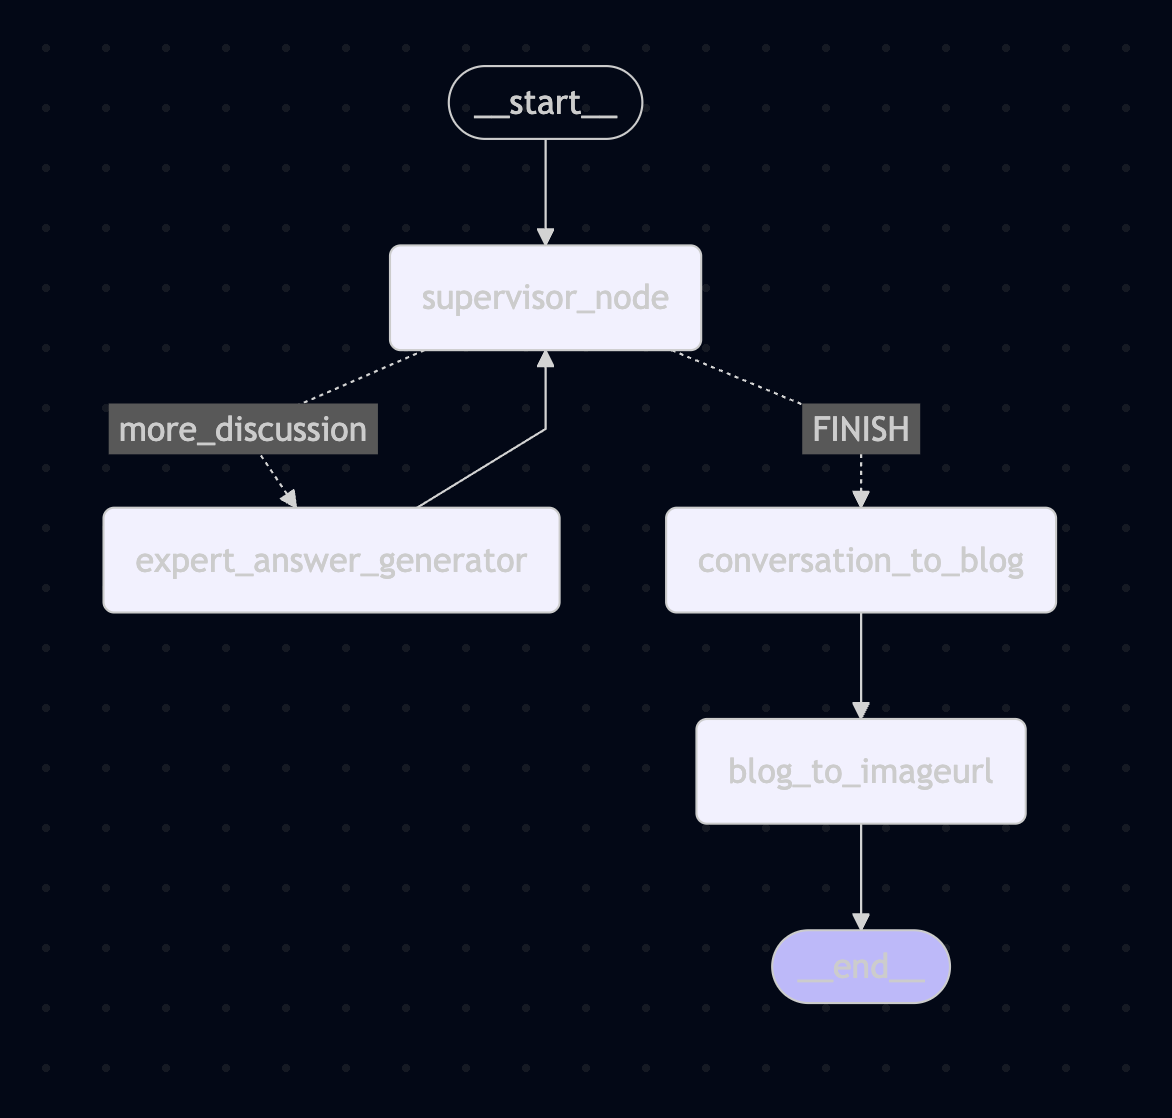
</div>


In [53]:
example_state = {
    "project_name": "CareConnect",
    "service_description": "고령층 사용자를 위한 비대면 진료 예약 및 건강관리 플랫폼입니다.",
    "target_users": "60대 이상 디지털 약자 및 그 가족",
    "core_features": "화상 진료 예약, 복약 알림, 건강 수치 모니터링, 보호자 공유 기능",

    "experts": [
        "의료 정보 접근성 연구자",
        "시니어 UX/UI 디자이너",
        "디지털 헬스케어 정책 전문가"
    ],
    "interview_questions": "고령층이 디지털 헬스케어 서비스를 쉽게 사용할 수 있도록 하려면 어떤 UI/UX 원칙이 중요할까요?",
    "problem_to_verify": "고령층이 실제로 디지털 의료 서비스를 사용하는 데 겪는 가장 큰 어려움은 무엇이며, 이를 해결하기 위한 제품 설계 방안은?",
    
    "messages": ["고령층 사용자를 위한 비대면 진료 예약 및 건강관리 플랫폼입니다. 고령층이 디지털 헬스케어 서비스를 쉽게 사용할 수 있도록 하려면 어떤 UI/UX 원칙이 중요할까요? 고령층이 실제로 디지털 의료 서비스를 사용하는 데 겪는 가장 큰 어려움은 무엇이며, 이를 해결하기 위한 제품 설계 방안은?"]
}

In [54]:
last_message = ""
last_expert = ""
experts_list = []
last_messages = []

def stream_graph_updates(user_input: str):
    for event in graph.stream(user_input):
        for value in event.values():
            print(value)
            # last_message = value.get("messages",None)
            # last_expert = value.get("next_speaker",None)
            # if last_expert:
            #     experts_list.append(last_expert)
            # if last_message:
            #     last_messages.append(last_message)
            # print("questions:", value["questions"][-1])
            # print("answers:", value["answers"][-1])
stream_graph_updates(example_state)

{'next_speaker': '시니어 UX/UI 디자이너'}
{'messages': ['고령층 사용자를 위한 비대면 진료 예약 및 건강관리 플랫폼입니다. 고령층이 디지털 헬스케어 서비스를 쉽게 사용할 수 있도록 하려면 어떤 UI/UX 원칙이 중요할까요? 고령층이 실제로 디지털 의료 서비스를 사용하는 데 겪는 가장 큰 어려움은 무엇이며, 이를 해결하기 위한 제품 설계 방안은?', '고령층 사용자가 쉽게 디지털 헬스케어 서비스를 이용할 수 있도록 하려면 **1) 직관적이고 분명한 네비게이션 구조**, **2) 명확하고 큰 글씨 및 대비가 높은 색채 사용**, **3) 단계별 안내 및 실수 예방 설계**가 중요합니다. 2021년 W3C의 접근성 가이드라인(WCAG 2.1)은 특히 고령층을 위해 단순하고 반복 가능한 인터페이스와 충분한 대기 시간을 강조합니다. 이러한 원칙을 제품에 반영하면, 사용자가 자신감을 갖고 서비스에 접근할 수 있습니다.']}
{'next_speaker': '디지털 헬스케어 정책 전문가'}
{'messages': ['고령층 사용자를 위한 비대면 진료 예약 및 건강관리 플랫폼입니다. 고령층이 디지털 헬스케어 서비스를 쉽게 사용할 수 있도록 하려면 어떤 UI/UX 원칙이 중요할까요? 고령층이 실제로 디지털 의료 서비스를 사용하는 데 겪는 가장 큰 어려움은 무엇이며, 이를 해결하기 위한 제품 설계 방안은?', '고령층 사용자가 쉽게 디지털 헬스케어 서비스를 이용할 수 있도록 하려면 **1) 직관적이고 분명한 네비게이션 구조**, **2) 명확하고 큰 글씨 및 대비가 높은 색채 사용**, **3) 단계별 안내 및 실수 예방 설계**가 중요합니다. 2021년 W3C의 접근성 가이드라인(WCAG 2.1)은 특히 고령층을 위해 단순하고 반복 가능한 인터페이스와 충분한 대기 시간을 강조합니다. 이러한 원칙을 제품에 반영하면, 사용자가 자신감을 갖고 서비스에 접근할 수 있습니다.', '고령층이 디지털 의료 서비스를 사용하는 데 가장 큰 어려움은 기술 사용에 